## New Beach Presence Notebook

Third figure request for Stephanie

In [1]:
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.cm as mcm
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
landcolour = 'papayawhip'
plt.rcParams['font.size'] = 15

In [3]:
minoil = 3 # litres per grid cell

In [4]:
data3d = xr.open_dataset('~/Documents/MIDOSS/MIDOSS_aggregated_merged.nc')

In [5]:
jmin, jmax = data3d.x.values[0], data3d.x.values[-1]
imin, imax = data3d.y.values[0], data3d.y.values[-1]
print (jmin, jmax, imin, imax)

100 339 500 769


In [6]:
mesh = xr.open_dataset('~/Documents/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]
dlat = mesh.nav_lat[imax, jmax] - mesh.nav_lat[imax-1, jmax-1]
dlon = mesh.nav_lon[imax, jmax] - mesh.nav_lon[imax-1, jmax-1]

In [7]:
raw = data3d.Beaching_Volume
raw

<xarray.DataArray 'Beaching_Volume' (RunId: 723, y: 270, x: 240)>
[46850400 values with dtype=float64]
Coordinates:
  * RunId    (RunId) object 'A-0' 'A-1' 'A-10' 'A-11' ... 'E-97' 'E-98' 'E-99'
  * y        (y) int64 500 501 502 503 504 505 506 ... 764 765 766 767 768 769
  * x        (x) int64 100 101 102 103 104 105 106 ... 334 335 336 337 338 339

In [8]:
oil_array = (raw > minoil/1000).astype(int).mean(axis=0)
print (oil_array.max())
oil = np.ma.masked_array(oil_array, oil_array < 0.01)  #mask anything less than 1%
print (oil.mask.min())

<xarray.DataArray 'Beaching_Volume' ()>
array(0.1604426)
False


/home/sallen/conda-envs/py39/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


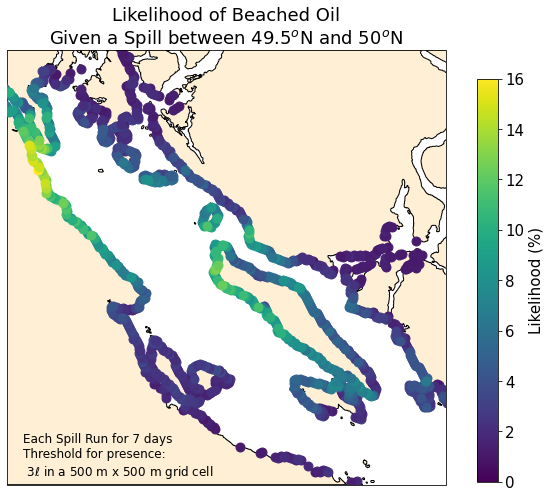

In [9]:
vmax = 16
normalize = colors.Normalize(vmin=0, vmax=vmax)
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
st = 2
for bt in range(0, vmax, st):
#    print (bt)
    for ii in range(imin, imax):
        for jj in range(jmin, jmax):
            if (oil[ii-imin, jj-jmin]*100 > bt) and (oil[ii-imin, jj-jmin]*100 < bt+st):
                ax.scatter(mesh.nav_lon[ii, jj] + dlon/2, mesh.nav_lat[ii, jj] + dlat/2, 
                           c=[oil[ii-imin, jj-jmin]*100], marker='o', s=80, 
                           transform=crs.PlateCarree(), zorder=bt+2, 
                           norm=normalize)
cax = fig.add_axes([0.86, 0.13, 0.03, 0.7])
cb = colorbar.ColorbarBase(cax, cmap=mcm.viridis, norm=normalize) 
cb.set_label('Likelihood (%)')
ax.set_title("Likelihood of Beached Oil\nGiven a Spill between 49.5$^o$N and 50$^o$N");
ax.text(-125.25, 49.32, f'Each Spill Run for 7 days\nThreshold for presence:\n {minoil}$\ell$ in a 500 m x 500 m grid cell',
       transform=crs.PlateCarree(), fontsize=12)
fig.savefig(f'BeachProb_2C_scatter_{minoil}.png', dpi=200)